# Advent of Haystack: Day 2

_Make a copy of this Colab to start_

In this challenge, your mission is to help a couple of fictional elves in the film "A Very Weaviate Christmas".
1. Find out what's happening in the film "A Very Weaviate Christmas"
2. This will lead you to a clue that will let you discover which Weaviate Collection to peak into.
3. While submitting the challenge, tell us what you find there!


### Components to use:
1. [`OpenAITextEmbedder`](https://docs.haystack.deepset.ai/docs/openaitextembedder)
2. [`OpenAIGenerator`](https://docs.haystack.deepset.ai/docs/openaigenerator)
3. [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder)
4. [`WeaviateDocumentStore`](https://docs.haystack.deepset.ai/docs/weaviatedocumentstore)
5. [`WeaviateEmbeddingRetriever`](https://docs.haystack.deepset.ai/reference/integrations-weaviate#weaviateembeddingretriever)


🎄 **Your task is to complete steps 3 and 4**. But make sure you run the code cells before. You should know what each prior step is doing.

## 1) Setup and Installation

In [1]:
!uv pip install haystack-ai weaviate-haystack
!uv pip install -q --upgrade openai # not to get the OpenAI proxies error: https://community.openai.com/t/error-with-openai-1-56-0-client-init-got-an-unexpected-keyword-argument-proxies/1040332/2

Audited 2 packages in 8ms


To get started, first provide your API keys below. We're providing you with a read-only API Key for Weaviate.

For this challenge, we've prepared a Weaviate Collection for you which contains lots of movies and their overviews.

In [2]:
import os
from getpass import getpass

os.environ["WEAVIATE_API_KEY"] = "b3jhGwa4NkLGjaq3v1V1vh1pTrlKjePZSt91"

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

## 2) Weaviate Setup

Next, you can connect to the right `WeaviateDocumentStore` (we've already added the right code for you below with the cleint URL in place).

In this document store, there are many movies, their titles and ther overviews.

In [3]:
from haystack_integrations.document_stores.weaviate import WeaviateDocumentStore, AuthApiKey
from haystack import Document
import os


auth_client_secret = AuthApiKey()

document_store = WeaviateDocumentStore(url="https://zgvjwlycsr6p5j1ziuyea.c0.europe-west3.gcp.weaviate.cloud",
                                       auth_client_secret=auth_client_secret)

/home/kalki/genAI/adventOfHaystack/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3) The RAG Pipeline

Now, you're on your own. Complete the code blocks below.

First, create a RAG pipeline that can answer questions based on the overviews of the movies in your `document_store`.

⭐️ You should then be able to run the pipeline and answer the questions "What happens in the film 'A Very Weaviate Christmas'?"

**💚 Hint 1:** The embedding model that was used to populate the vectors was `text-embedding-3-small` by OpenAI.

**💙 Hint 2:** We've added an import to the OpenAIGenerator but feel free to use something else!

In [16]:
from haystack import Pipeline
from haystack.components.embedders import OpenAITextEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders import PromptBuilder
from haystack_integrations.components.retrievers.weaviate import WeaviateEmbeddingRetriever

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

rag = Pipeline()

rag.add_component("text_embedder", OpenAITextEmbedder(model="text-embedding-3-small"))

rag.add_component("retriever", WeaviateEmbeddingRetriever(document_store=document_store))

rag.add_component("prompt_builder", PromptBuilder(template=template))

rag.add_component("llm", OpenAIGenerator(model="gpt-4o-mini"))

In [17]:
rag.connect("text_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: OpenAITextEmbedder
  - retriever: WeaviateEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

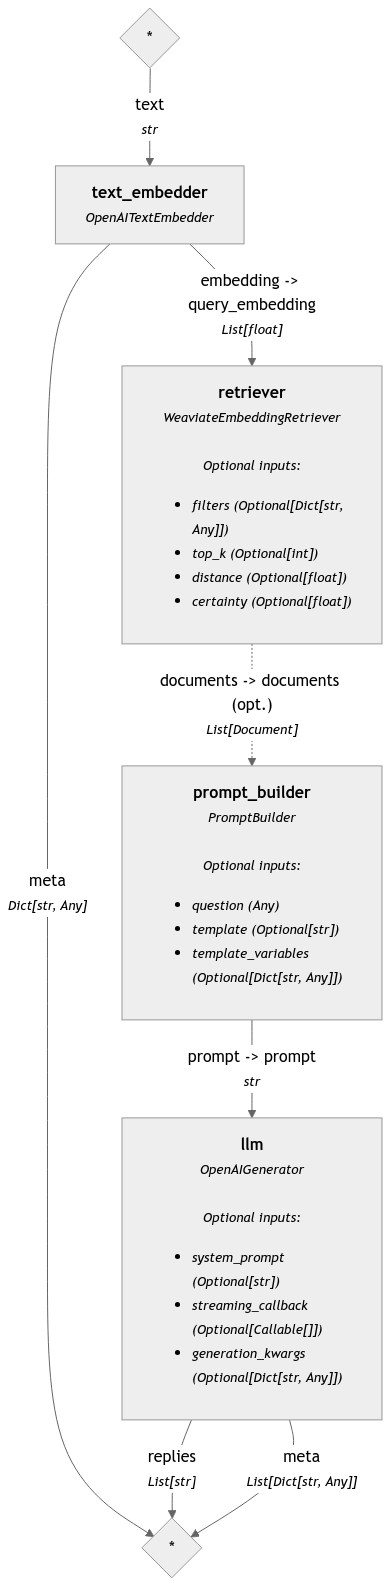

In [18]:
rag.show()

In [19]:
query = "What happens in the film 'A Very Weaviate Christmas'?"
reply = rag.run({"text_embedder": {"text": query}, "prompt_builder": {"question": query}})

In [22]:
print(reply["llm"]["replies"][0])

In the film 'A Very Weaviate Christmas', the story revolves around two of Santa's elves, Daniel and Philip, who embark on a thrilling adventure to recover stolen vectors that have been hidden by an intruder in an unknown Collection. The elves race against time to find these vectors before Christmas Day, leading them to a location known as "Santas_Grotto". As they navigate their mission, viewers are treated to a mix of excitement and holiday spirit, featuring the Weaviate DevRel and Growth teams in this festive drama.


## 4) Solve the Mystery

By this point, you should know what's happening.. There is a Collection where everything has been hidden.

Complete the code cell below by providing the right Collection name, and tell us the following:

1. Who is the culprit? Watch out, because there may be `decoys`.
2. What have they stolen?

**💚 Hint:** Once you've connected to the right collection, take a look at all the Objects in there. Then, you may be able to use filters to avoid the decoys!

- [Weaviate Documentation: Read all Objects](https://weaviate.io/developers/weaviate/manage-data/read-all-objects)
- [Weaviate Documentation: Filters](https://weaviate.io/developers/weaviate/search/filters)

In [23]:
import weaviate

from weaviate.classes.init import Auth

headers = {"X-OpenAI-Api-Key": os.getenv("OPENAI_API_KEY")}
client = weaviate.connect_to_weaviate_cloud(cluster_url="https://zgvjwlycsr6p5j1ziuyea.c0.europe-west3.gcp.weaviate.cloud",
                                            auth_credentials=Auth.api_key(os.getenv("WEAVIATE_API_KEY")),
                                            headers=headers)

# Provide the name of the collection in client.collections.get() below 👇
plot = client.collections.get("Santas_Grotto")

In [27]:
from weaviate.classes.query import Filter

culprit = plot.query.fetch_objects(
    filters=Filter.by_property("decoy").equal(False)
)

In [34]:
for c in culprit.objects:
    print(c.properties['plot'])

Tuana is here with not just all the vectors but also all the presents that are supposed to be delivered around the World!


## Thus the Culprit is...
# Tuana